In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sns

import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings(action='ignore')


In [2]:
df = pd.read_csv("SHR76_20.csv")

# Feature Cleaning
df.insert(1, 'County', df['CNTYFIPS'].map(lambda x : str(x).split(',')[0]), True)
df.drop("CNTYFIPS",axis = 1, inplace= True) # redundant, onlyy keeping the county part
df.drop("StateName",axis = 1, inplace= True)  # redundant, contains state
df.drop("Ori",axis = 1, inplace= True)  # redundant, contains state + county + agentcy nb
df.insert(3, 'Area',df['MSA'].map(lambda x :  str(x).split(',')[0] ) ,True)
df.drop('MSA',axis = 1,inplace=True) # rendundant only the state, keeping the metropolitant statistical area

df.drop("Incident",axis = 1,inplace = True) # incient number of the month, for a specific county useless for our application

df.drop("Situation",axis = 1,inplace = True) # redundant, info already contained in OffCount and VicCount

df.drop(["Source","ID","Solved","FileDate","ActionType"],axis = 1,inplace = True)

# Values cleaning
df['OffAge'].replace(999, np.NaN, inplace=True) # replacing 999 ages with Nan
df = df[df["Agentype"]!='4'] # removing 4 4s typo?

df["OffAge"] = pd.cut(df['OffAge'], bins = [0,2,14,18,22,30,40,50,60,70,80,100], labels = ['0-2','3-14', '15-18', '19-22', '23-30', '30s','40s','50s','60s','70s','80+'])
df["VicAge"] = pd.cut(df['VicAge'], bins = [0,2,14,18,22,30,40,50,60,70,80,100], labels = ['0-2','3-14', '15-18', '19-22', '23-30', '30s','40s','50s','60s','70s','80+'])

C:\Users\louis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_sub = df

print(len(df_sub))
df_sub_full = df_sub.dropna()
print(len(df_sub_full))

for col in df_sub.columns:
    try:
        df_sub_full = df_sub_full[df_sub_full[col].str.contains("nknown|undetermined|not specified",regex = True)==False]
    except:
            a=0
print(len(df_sub_full))

827215
27254
12717


In [4]:
input_cols = ["County","State",'Area','Agency', 'Agentype', 'Year', 'Month','Homicide', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic','Weapon', 'Circumstance', 'Subcircum', 'VicCount']

to_dummy = ["County","State",'Area','Agency', 'Agentype','VicRace', 'VicAge','VicEthnic','Weapon', 'Circumstance', 'Subcircum']
dumies = pd.get_dummies(df_sub_full[to_dummy])
dummied = df_sub_full[input_cols].drop(to_dummy,axis = 1)
X = dummied.join(dumies)
X.columns

Index(['Year', 'Month', 'Homicide', 'VicSex', 'VicCount', 'County_Ada',
       'County_Adair', 'County_Adams', 'County_Aiken', 'County_Aitkin',
       ...
       'Weapon_Strangulation - hanging', 'Circumstance_Felon killed by police',
       'Circumstance_Felon killed by private citizen',
       'Subcircum_Felon attacked a civilian',
       'Subcircum_Felon attacked fellow police officer',
       'Subcircum_Felon attacked police officer',
       'Subcircum_Felon attempted flight from a crime',
       'Subcircum_Felon killed in commission of a crime',
       'Subcircum_Felon resisted arrest',
       'Subcircum_Not enough information to determine'],
      dtype='object', length=2875)

In [5]:
def to_numeric(X):
    X_numeric = X.copy(deep=True)

    for col in tqdm(X.columns):
        if str(X[col].dtypes) == 'object' or str(X[col].dtypes)== 'category':
            labels = X_numeric[col].unique().tolist()
            mapping = dict(zip(labels,range(0,len(labels))))
            X_numeric.replace({col: mapping},inplace=True)
            X_numeric[col].astype(int)
    return X_numeric

X_numeric = to_numeric(X)  
len(X_numeric)

100%|██████████| 2875/2875 [00:00<00:00, 9944.35it/s]


12717

In [6]:
output_cols = ['OffAge','Relationship','OffSex', 'OffRace', 'OffEthnic','OffCount']
Y = df_sub_full[output_cols]

Y_numeric = to_numeric(Y)  
len(Y_numeric)

100%|██████████| 6/6 [00:00<00:00, 53.71it/s]


12717

In [59]:
def build_model(model):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    scores = [];   cms = []
    col_nb = 0;
    for col in output_cols:
        col_scores = [];     col_cms = []
        i=0; fig = plt.figure(figsize=(6,5))
        for train_index, test_index in skf.split(X_numeric, Y_numeric[col]):
            x_train_fold, x_test_fold = X_numeric.iloc[train_index], X_numeric.iloc[test_index]
            y_train_fold, y_test_fold = Y_numeric[col].iloc[train_index], Y_numeric[col].iloc[test_index]
            model.fit(x_train_fold, y_train_fold)
            preds = model.predict(x_test_fold)
            prfs = list(precision_recall_fscore_support(y_test_fold,preds,average="weighted"))[0:3]
            prfs.append(model.score(x_test_fold, y_test_fold))
            col_scores.append(prfs)
            ax = fig.add_subplot(1, 1, 1)
            if i == 1:  plot_confusion_matrix(ax=ax,X = x_test_fold, y_true = y_test_fold, estimator=model)
            i+=1;
        scores.append((col,np.mean(col_scores,axis = 0)))
        col_nb+=1;
    scores_df = pd.DataFrame(columns=["precision", "recall", "f1score", "accuracy"])
    for col in scores:
        scores_df.loc[col[0]]= col[1]
    return scores_df

,precision,recall,f1score,accuracy
OffAge,0.285251,0.357236,0.291781,0.357236
Relationship,0.586007,0.749469,0.643153,0.749469
OffSex,0.867123,0.931195,0.898018,0.931195
OffRace,0.787565,0.812614,0.791971,0.812614
OffEthnic,0.805510,0.831485,0.783919,0.831485
OffCount,0.736409,0.858143,0.792629,0.858143


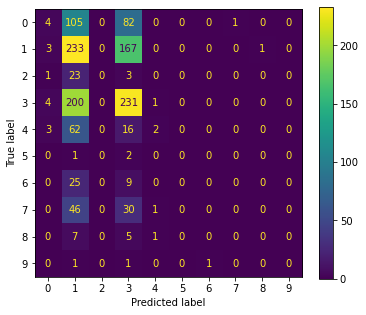

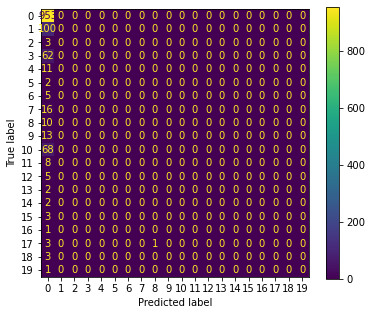

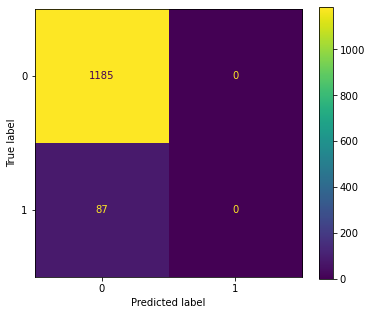

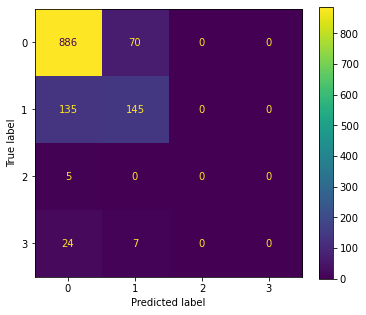

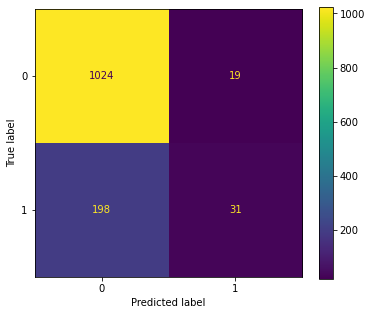

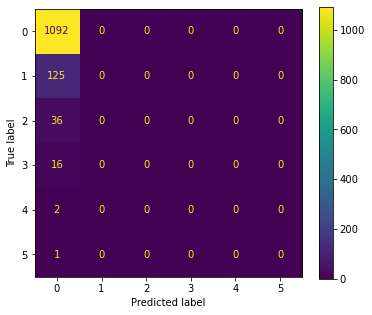

In [60]:
results = build_model(ComplementNB(norm=True)) 
results      

,precision,recall,f1score,accuracy
OffAge,0.260686,0.059447,0.078084,0.059447
Relationship,0.613213,0.141230,0.206816,0.141230
OffSex,0.878880,0.295272,0.388319,0.295272
OffRace,0.736244,0.246128,0.332463,0.246128
OffEthnic,0.828733,0.431233,0.460058,0.431233
OffCount,0.783721,0.205316,0.299550,0.205316


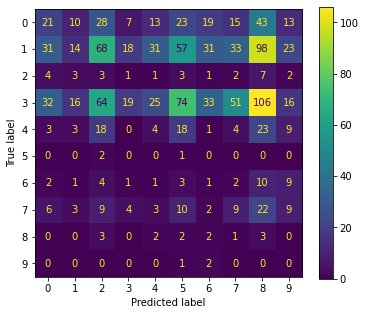

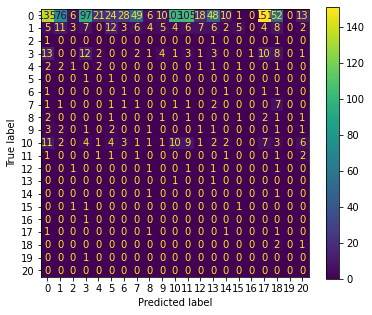

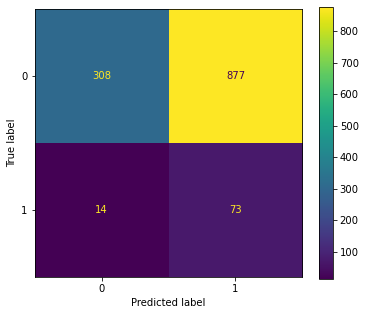

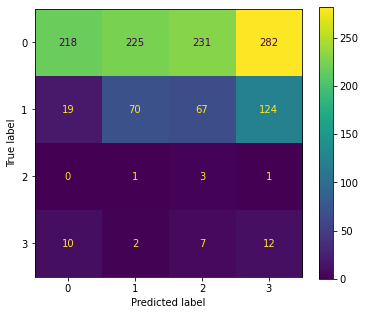

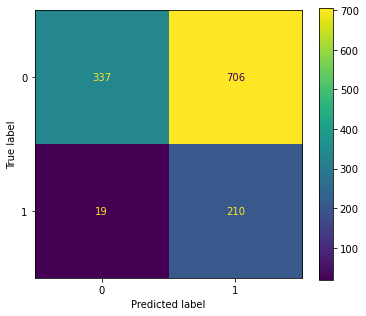

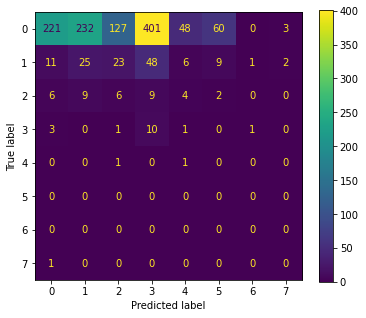

In [61]:
results= build_model(GaussianNB())
results

,precision,recall,f1score,accuracy
OffAge,0.304629,0.292678,0.294973,0.292678
Relationship,0.682801,0.639066,0.655422,0.639066
OffSex,0.893498,0.829755,0.857434,0.829755
OffRace,0.808168,0.764567,0.772997,0.764567
OffEthnic,0.825841,0.705908,0.738297,0.705908
OffCount,0.813997,0.682866,0.734250,0.682866


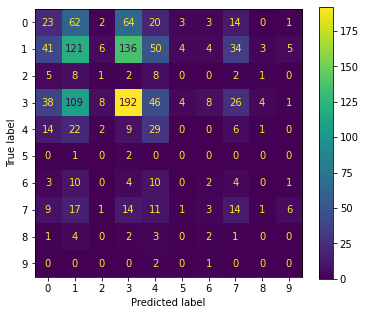

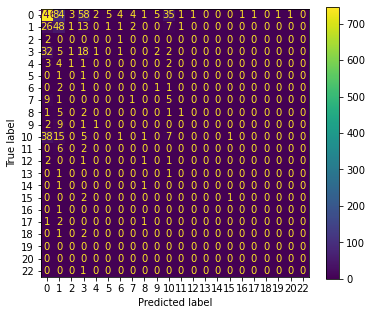

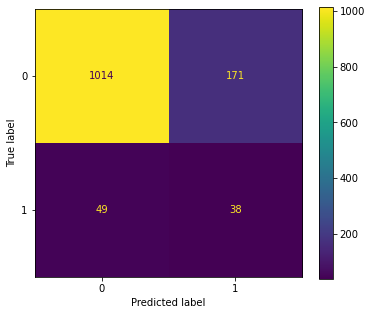

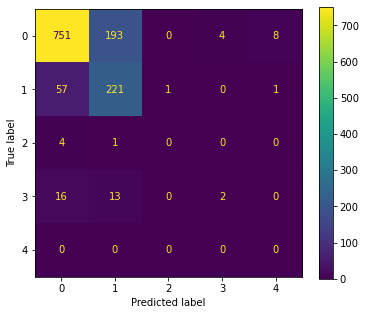

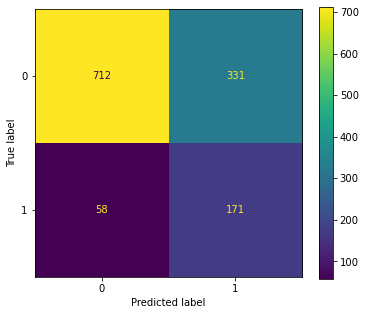

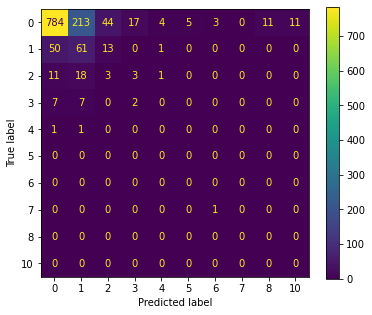

In [62]:
results = build_model(ComplementNB())
results